# Global Mean Surface Temperature

This notebook uses similar techniques to `ECS_Gregory_method.ipynb`. Please refer to that notebook for details.

In [1]:
import dask
import fsspec
import intake
import numpy as np
import seaborn as sns
import xarray as xr
from dask.diagnostics import progress
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,unique
activity_id,15
institution_id,34
source_id,79
experiment_id,107
member_id,213
table_id,30
variable_id,392
grid_label,10
zstore,294376
dcpp_init_year,60


In [3]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['ssp370',
 'esm-ssp585',
 'ssp126',
 'ssp245',
 'ssp585',
 'ssp245-GHG',
 'ssp245-aer',
 'ssp245-nat',
 'ssp245-stratO3',
 'esm-ssp585-ssp126Lu',
 'ssp119',
 'ssp434',
 'ssp460',
 'ssp534-over']

In [4]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp245', 'ssp585']

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['tas'],
    member_id='r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id"]].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,3,1,1
ACCESS-ESM1-5,3,1,1
AWI-CM-1-1-MR,3,1,1
BCC-CSM2-MR,3,1,1
CAMS-CSM1-0,3,1,1
CESM2-WACCM,3,1,1
CIESM,3,1,1
CMCC-CM2-SR5,3,1,1
CanESM5,3,1,1


In [5]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords if (('_bounds') in vname) or ('_bnds') in vname]
    return ds.drop(drop_vars)


def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)


def open_delayed(df):
    return dask.delayed(open_dset)(df)


from collections import defaultdict

dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [6]:
dsets_ = dask.compute(dict(dsets))[0]

In [7]:
# calculate global means


def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")


def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [8]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id', coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [
        v[expt].pipe(global_mean).swap_dims({'time': 'year'}).drop('time').coarsen(year=12).mean() for expt in expts
    ]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer', dim=expt_da)

In [9]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

[                                        ] | 0% Completed |  0.0s

[                                        ] | 0% Completed |  0.3s

[                                        ] | 0% Completed |  0.4s

[                                        ] | 0% Completed |  0.5s

[                                        ] | 0% Completed |  0.6s

[                                        ] | 0% Completed |  0.7s

[                                        ] | 0% Completed |  0.8s

[                                        ] | 0% Completed |  0.9s

[                                        ] | 0% Completed |  1.0s

[                                        ] | 0% Completed |  1.1s

[                                        ] | 0% Completed |  1.2s

[                                        ] | 0% Completed |  1.3s

[                                        ] | 0% Completed |  1.4s

[                                        ] | 0% Completed |  1.5s

[                                        ] | 0% Completed |  1.6s

[                                        ] | 0% Completed |  1.7s

[                                        ] | 0% Completed |  1.8s

[                                        ] | 1% Completed |  1.9s

[                                        ] | 1% Completed |  2.0s

[                                        ] | 1% Completed |  2.2s

[                                        ] | 1% Completed |  2.3s

[                                        ] | 1% Completed |  2.4s

[                                        ] | 1% Completed |  2.5s

[                                        ] | 1% Completed |  2.6s

[                                        ] | 1% Completed |  2.7s

[                                        ] | 2% Completed |  2.9s

[                                        ] | 2% Completed |  3.0s

[                                        ] | 2% Completed |  3.1s

[#                                       ] | 2% Completed |  3.2s

[#                                       ] | 2% Completed |  3.3s

[#                                       ] | 3% Completed |  3.4s

[#                                       ] | 3% Completed |  3.5s

[#                                       ] | 3% Completed |  3.6s

[#                                       ] | 3% Completed |  3.7s

[#                                       ] | 3% Completed |  3.8s

[#                                       ] | 3% Completed |  3.9s

[##                                      ] | 5% Completed |  4.0s

[##                                      ] | 5% Completed |  4.2s

[##                                      ] | 5% Completed |  4.3s

[##                                      ] | 5% Completed |  4.4s

[##                                      ] | 5% Completed |  4.5s

[##                                      ] | 6% Completed |  4.6s

[##                                      ] | 6% Completed |  4.7s

[##                                      ] | 6% Completed |  4.8s

[##                                      ] | 7% Completed |  4.9s

[##                                      ] | 7% Completed |  5.0s

[###                                     ] | 8% Completed |  5.1s

[###                                     ] | 8% Completed |  5.2s

[###                                     ] | 8% Completed |  5.3s

[####                                    ] | 10% Completed |  5.5s

[####                                    ] | 10% Completed |  5.6s

[####                                    ] | 11% Completed |  5.7s

[####                                    ] | 11% Completed |  5.8s

[####                                    ] | 11% Completed |  5.9s

[####                                    ] | 12% Completed |  6.0s

[####                                    ] | 12% Completed |  6.1s

[####                                    ] | 12% Completed |  6.2s

[#####                                   ] | 12% Completed |  6.3s

[#####                                   ] | 12% Completed |  6.4s

[#####                                   ] | 12% Completed |  6.5s

[#####                                   ] | 13% Completed |  6.6s

[#####                                   ] | 13% Completed |  6.7s

[#####                                   ] | 13% Completed |  6.9s

[#####                                   ] | 13% Completed |  7.0s

[#####                                   ] | 13% Completed |  7.1s

[#####                                   ] | 14% Completed |  7.2s

[#####                                   ] | 14% Completed |  7.3s

[#####                                   ] | 14% Completed |  7.4s

[#####                                   ] | 14% Completed |  7.5s

[#####                                   ] | 14% Completed |  7.6s

[#####                                   ] | 14% Completed |  7.7s

[#####                                   ] | 14% Completed |  7.8s

[#####                                   ] | 14% Completed |  7.9s

[#####                                   ] | 14% Completed |  8.0s

[#####                                   ] | 14% Completed |  8.1s

[######                                  ] | 15% Completed |  8.2s

[######                                  ] | 15% Completed |  8.3s

[######                                  ] | 15% Completed |  8.4s

[######                                  ] | 15% Completed |  8.5s

[######                                  ] | 15% Completed |  8.6s

[######                                  ] | 15% Completed |  8.7s

[######                                  ] | 15% Completed |  8.8s

[######                                  ] | 15% Completed |  8.9s

[######                                  ] | 15% Completed |  9.0s

[######                                  ] | 15% Completed |  9.1s

[######                                  ] | 15% Completed |  9.2s

[######                                  ] | 16% Completed |  9.3s

[######                                  ] | 16% Completed |  9.4s

[######                                  ] | 16% Completed |  9.5s

[######                                  ] | 16% Completed |  9.6s

[######                                  ] | 16% Completed |  9.7s

[######                                  ] | 16% Completed |  9.8s

[######                                  ] | 16% Completed | 10.0s

[######                                  ] | 16% Completed | 10.1s

[######                                  ] | 16% Completed | 10.2s

[######                                  ] | 16% Completed | 10.3s

[######                                  ] | 16% Completed | 10.4s

[######                                  ] | 16% Completed | 10.5s

[######                                  ] | 16% Completed | 10.6s

[######                                  ] | 16% Completed | 10.8s

[######                                  ] | 16% Completed | 10.9s

[######                                  ] | 16% Completed | 11.0s

[######                                  ] | 16% Completed | 11.2s

[######                                  ] | 16% Completed | 11.3s

[######                                  ] | 16% Completed | 11.4s

[######                                  ] | 16% Completed | 11.5s

[######                                  ] | 16% Completed | 11.7s

[######                                  ] | 16% Completed | 11.8s

[######                                  ] | 16% Completed | 11.9s

[######                                  ] | 16% Completed | 12.0s

[######                                  ] | 16% Completed | 12.1s

[######                                  ] | 16% Completed | 12.2s

[######                                  ] | 17% Completed | 12.3s

[######                                  ] | 17% Completed | 12.4s

[######                                  ] | 17% Completed | 12.5s

[######                                  ] | 17% Completed | 12.6s

[######                                  ] | 17% Completed | 12.8s

[######                                  ] | 17% Completed | 12.9s

[######                                  ] | 17% Completed | 13.0s

[######                                  ] | 17% Completed | 13.1s

[######                                  ] | 17% Completed | 13.2s

[######                                  ] | 17% Completed | 13.3s

[######                                  ] | 17% Completed | 13.4s

[######                                  ] | 17% Completed | 13.5s

[######                                  ] | 17% Completed | 13.6s

[######                                  ] | 17% Completed | 13.7s

[#######                                 ] | 17% Completed | 13.8s

[#######                                 ] | 17% Completed | 13.9s

[#######                                 ] | 17% Completed | 14.0s

[#######                                 ] | 17% Completed | 14.2s

[#######                                 ] | 17% Completed | 14.3s

[#######                                 ] | 17% Completed | 14.4s

[#######                                 ] | 17% Completed | 14.5s

[#######                                 ] | 18% Completed | 14.6s

[#######                                 ] | 18% Completed | 14.7s

[#######                                 ] | 18% Completed | 14.8s

[#######                                 ] | 18% Completed | 14.9s

[#######                                 ] | 18% Completed | 15.0s

[#######                                 ] | 18% Completed | 15.1s

[#######                                 ] | 18% Completed | 15.2s

[#######                                 ] | 18% Completed | 15.3s

[#######                                 ] | 18% Completed | 15.4s

[#######                                 ] | 18% Completed | 15.5s

[#######                                 ] | 18% Completed | 15.6s

[#######                                 ] | 18% Completed | 15.7s

[#######                                 ] | 18% Completed | 15.8s

[#######                                 ] | 18% Completed | 15.9s

[#######                                 ] | 18% Completed | 16.1s

[#######                                 ] | 18% Completed | 16.2s

[#######                                 ] | 18% Completed | 16.3s

[#######                                 ] | 18% Completed | 16.4s

[#######                                 ] | 18% Completed | 16.5s

[#######                                 ] | 18% Completed | 16.6s

[#######                                 ] | 19% Completed | 16.8s

[#######                                 ] | 19% Completed | 16.9s

[#######                                 ] | 19% Completed | 17.0s

[#######                                 ] | 19% Completed | 17.1s

[#######                                 ] | 19% Completed | 17.2s

[#######                                 ] | 19% Completed | 17.4s

[#######                                 ] | 19% Completed | 17.5s

[#######                                 ] | 19% Completed | 17.6s

[#######                                 ] | 19% Completed | 17.7s

[#######                                 ] | 19% Completed | 17.8s

[#######                                 ] | 19% Completed | 17.9s

[#######                                 ] | 19% Completed | 18.0s

[#######                                 ] | 19% Completed | 18.1s

[#######                                 ] | 19% Completed | 18.2s

[#######                                 ] | 19% Completed | 18.3s

[#######                                 ] | 19% Completed | 18.5s

[#######                                 ] | 19% Completed | 18.6s

[########                                ] | 20% Completed | 18.7s

[########                                ] | 20% Completed | 18.8s

[########                                ] | 20% Completed | 18.9s

[########                                ] | 20% Completed | 19.0s

[########                                ] | 20% Completed | 19.1s

[########                                ] | 20% Completed | 19.2s

[########                                ] | 20% Completed | 19.3s

[########                                ] | 20% Completed | 19.5s

[########                                ] | 20% Completed | 19.6s

[########                                ] | 20% Completed | 19.7s

[########                                ] | 20% Completed | 19.8s

[########                                ] | 20% Completed | 19.9s

[########                                ] | 20% Completed | 20.0s

[########                                ] | 20% Completed | 20.1s

[########                                ] | 20% Completed | 20.3s

[########                                ] | 20% Completed | 20.4s

[########                                ] | 20% Completed | 20.5s

[########                                ] | 20% Completed | 20.6s

[########                                ] | 20% Completed | 20.7s

[########                                ] | 20% Completed | 20.8s

[########                                ] | 20% Completed | 20.9s

[########                                ] | 20% Completed | 21.0s

[########                                ] | 21% Completed | 21.1s

[########                                ] | 21% Completed | 21.2s

[########                                ] | 21% Completed | 21.3s

[########                                ] | 21% Completed | 21.4s

[########                                ] | 21% Completed | 21.5s

[########                                ] | 21% Completed | 21.7s

[########                                ] | 21% Completed | 21.8s

[########                                ] | 21% Completed | 21.9s

[########                                ] | 22% Completed | 22.0s

[########                                ] | 22% Completed | 22.1s

[########                                ] | 22% Completed | 22.2s

[########                                ] | 22% Completed | 22.4s

[########                                ] | 22% Completed | 22.5s

[########                                ] | 22% Completed | 22.7s

[########                                ] | 22% Completed | 22.8s

[########                                ] | 22% Completed | 22.9s

[########                                ] | 22% Completed | 23.0s

[########                                ] | 22% Completed | 23.1s

[#########                               ] | 22% Completed | 23.2s

[#########                               ] | 22% Completed | 23.4s

[#########                               ] | 23% Completed | 23.5s

[#########                               ] | 23% Completed | 23.6s

[#########                               ] | 23% Completed | 23.7s

[#########                               ] | 23% Completed | 23.8s

[#########                               ] | 23% Completed | 23.9s

[#########                               ] | 23% Completed | 24.0s

[#########                               ] | 23% Completed | 24.1s

[#########                               ] | 23% Completed | 24.2s

[#########                               ] | 23% Completed | 24.3s

[#########                               ] | 23% Completed | 24.5s

[#########                               ] | 23% Completed | 24.6s

[#########                               ] | 23% Completed | 24.7s

[#########                               ] | 23% Completed | 24.8s

[#########                               ] | 23% Completed | 24.9s

[#########                               ] | 24% Completed | 25.0s

[#########                               ] | 24% Completed | 25.2s

[#########                               ] | 24% Completed | 25.3s

[#########                               ] | 24% Completed | 25.4s

[#########                               ] | 24% Completed | 25.5s

[#########                               ] | 24% Completed | 25.7s

[#########                               ] | 24% Completed | 25.8s

[##########                              ] | 25% Completed | 25.9s

[##########                              ] | 25% Completed | 26.0s

[##########                              ] | 25% Completed | 26.1s

[##########                              ] | 25% Completed | 26.2s

[##########                              ] | 25% Completed | 26.3s

[##########                              ] | 25% Completed | 26.4s

[##########                              ] | 26% Completed | 26.5s

[##########                              ] | 26% Completed | 26.7s

[##########                              ] | 26% Completed | 26.8s

[##########                              ] | 26% Completed | 26.9s

[##########                              ] | 27% Completed | 27.0s

[##########                              ] | 27% Completed | 27.1s

[##########                              ] | 27% Completed | 27.2s

[###########                             ] | 27% Completed | 27.3s

[###########                             ] | 27% Completed | 27.5s

[###########                             ] | 27% Completed | 27.6s

[###########                             ] | 27% Completed | 27.7s

[###########                             ] | 27% Completed | 27.8s

[###########                             ] | 27% Completed | 27.9s

[###########                             ] | 27% Completed | 28.1s

[###########                             ] | 27% Completed | 28.2s

[###########                             ] | 27% Completed | 28.3s

[###########                             ] | 27% Completed | 28.4s

[###########                             ] | 28% Completed | 28.5s

[###########                             ] | 28% Completed | 28.6s

[###########                             ] | 28% Completed | 28.7s

[###########                             ] | 28% Completed | 28.8s

[###########                             ] | 28% Completed | 28.9s

[###########                             ] | 28% Completed | 29.1s

[###########                             ] | 28% Completed | 29.2s

[###########                             ] | 28% Completed | 29.3s

[###########                             ] | 28% Completed | 29.4s

[###########                             ] | 28% Completed | 29.5s

[###########                             ] | 28% Completed | 29.6s

[###########                             ] | 28% Completed | 29.8s

[###########                             ] | 28% Completed | 29.9s

[###########                             ] | 28% Completed | 30.0s

[###########                             ] | 28% Completed | 30.1s

[###########                             ] | 29% Completed | 30.2s

[###########                             ] | 29% Completed | 30.3s

[###########                             ] | 29% Completed | 30.4s

[###########                             ] | 29% Completed | 30.5s

[###########                             ] | 29% Completed | 30.6s

[###########                             ] | 29% Completed | 30.8s

[###########                             ] | 29% Completed | 30.9s

[###########                             ] | 29% Completed | 31.0s

[###########                             ] | 29% Completed | 31.1s

[###########                             ] | 29% Completed | 31.2s

[###########                             ] | 29% Completed | 31.3s

[###########                             ] | 29% Completed | 31.4s

[###########                             ] | 29% Completed | 31.5s

[###########                             ] | 29% Completed | 31.6s

[###########                             ] | 29% Completed | 31.7s

[###########                             ] | 29% Completed | 31.8s

[###########                             ] | 29% Completed | 31.9s

[###########                             ] | 29% Completed | 32.1s

[###########                             ] | 29% Completed | 32.2s

[###########                             ] | 29% Completed | 32.3s

[############                            ] | 30% Completed | 32.4s

[############                            ] | 30% Completed | 32.5s

[############                            ] | 30% Completed | 32.6s

[############                            ] | 30% Completed | 32.7s

[############                            ] | 30% Completed | 32.8s

[############                            ] | 30% Completed | 32.9s

[############                            ] | 30% Completed | 33.0s

[############                            ] | 30% Completed | 33.1s

[############                            ] | 30% Completed | 33.2s

[############                            ] | 30% Completed | 33.3s

[############                            ] | 30% Completed | 33.4s

[############                            ] | 31% Completed | 33.5s

[############                            ] | 31% Completed | 33.6s

[############                            ] | 31% Completed | 33.7s

[############                            ] | 31% Completed | 33.9s

[############                            ] | 31% Completed | 34.0s

[############                            ] | 31% Completed | 34.1s

[############                            ] | 31% Completed | 34.2s

[############                            ] | 31% Completed | 34.3s

[#############                           ] | 32% Completed | 34.4s

[#############                           ] | 32% Completed | 34.5s

[#############                           ] | 33% Completed | 34.6s

[#############                           ] | 33% Completed | 34.7s

[#############                           ] | 33% Completed | 34.8s

[#############                           ] | 33% Completed | 34.9s

[#############                           ] | 33% Completed | 35.1s

[#############                           ] | 33% Completed | 35.2s

[#############                           ] | 33% Completed | 35.3s

[#############                           ] | 33% Completed | 35.4s

[#############                           ] | 33% Completed | 35.5s

[#############                           ] | 33% Completed | 35.6s

[#############                           ] | 33% Completed | 35.8s

[#############                           ] | 33% Completed | 35.9s

[#############                           ] | 33% Completed | 36.0s

[#############                           ] | 33% Completed | 36.1s

[#############                           ] | 33% Completed | 36.2s

[#############                           ] | 33% Completed | 36.3s

[#############                           ] | 33% Completed | 36.4s

[#############                           ] | 34% Completed | 36.6s

[#############                           ] | 34% Completed | 36.7s

[#############                           ] | 34% Completed | 36.8s

[#############                           ] | 34% Completed | 36.9s

[#############                           ] | 34% Completed | 37.0s

[#############                           ] | 34% Completed | 37.1s

[#############                           ] | 34% Completed | 37.2s

[#############                           ] | 34% Completed | 37.3s

[#############                           ] | 34% Completed | 37.4s

[#############                           ] | 34% Completed | 37.5s

[#############                           ] | 34% Completed | 37.6s

[#############                           ] | 34% Completed | 37.7s

[#############                           ] | 34% Completed | 37.8s

[#############                           ] | 34% Completed | 37.9s

[#############                           ] | 34% Completed | 38.0s

[#############                           ] | 34% Completed | 38.1s

[#############                           ] | 34% Completed | 38.2s

[#############                           ] | 34% Completed | 38.4s

[#############                           ] | 34% Completed | 38.5s

[#############                           ] | 34% Completed | 38.6s

[##############                          ] | 35% Completed | 38.7s

[##############                          ] | 35% Completed | 38.8s

[##############                          ] | 35% Completed | 38.9s

[##############                          ] | 35% Completed | 39.0s

[##############                          ] | 35% Completed | 39.1s

[##############                          ] | 35% Completed | 39.2s

[##############                          ] | 35% Completed | 39.3s

[##############                          ] | 36% Completed | 39.4s

[##############                          ] | 36% Completed | 39.6s

[##############                          ] | 36% Completed | 39.7s

[##############                          ] | 36% Completed | 39.8s

[##############                          ] | 36% Completed | 39.9s

[##############                          ] | 36% Completed | 40.0s

[##############                          ] | 36% Completed | 40.1s

[##############                          ] | 36% Completed | 40.2s

[##############                          ] | 36% Completed | 40.3s

[##############                          ] | 36% Completed | 40.4s

[##############                          ] | 36% Completed | 40.6s

[##############                          ] | 37% Completed | 40.7s

[##############                          ] | 37% Completed | 40.8s

[##############                          ] | 37% Completed | 40.9s

[##############                          ] | 37% Completed | 41.0s

[##############                          ] | 37% Completed | 41.1s

[###############                         ] | 37% Completed | 41.2s

[###############                         ] | 37% Completed | 41.4s

[###############                         ] | 37% Completed | 41.5s

[###############                         ] | 37% Completed | 41.6s

[###############                         ] | 38% Completed | 41.7s

[###############                         ] | 38% Completed | 41.8s

[###############                         ] | 38% Completed | 42.0s

[###############                         ] | 38% Completed | 42.1s

[###############                         ] | 38% Completed | 42.2s

[###############                         ] | 38% Completed | 42.3s

[###############                         ] | 38% Completed | 42.4s

[###############                         ] | 39% Completed | 42.5s

[###############                         ] | 39% Completed | 42.6s

[###############                         ] | 39% Completed | 42.7s

[################                        ] | 40% Completed | 42.8s

[################                        ] | 40% Completed | 42.9s

[################                        ] | 40% Completed | 43.0s

[################                        ] | 40% Completed | 43.1s

[################                        ] | 40% Completed | 43.2s

[################                        ] | 40% Completed | 43.3s

[################                        ] | 40% Completed | 43.4s

[################                        ] | 40% Completed | 43.5s

[################                        ] | 40% Completed | 43.7s

[################                        ] | 40% Completed | 43.8s

[################                        ] | 40% Completed | 43.9s

[################                        ] | 40% Completed | 44.0s

[################                        ] | 40% Completed | 44.1s

[################                        ] | 40% Completed | 44.2s

[################                        ] | 40% Completed | 44.3s

[################                        ] | 40% Completed | 44.5s

[################                        ] | 40% Completed | 44.6s

[################                        ] | 40% Completed | 44.7s

[################                        ] | 40% Completed | 44.8s

[################                        ] | 40% Completed | 44.9s

[################                        ] | 40% Completed | 45.0s

[################                        ] | 40% Completed | 45.1s

[################                        ] | 40% Completed | 45.2s

[################                        ] | 41% Completed | 45.4s

[################                        ] | 41% Completed | 45.5s

[################                        ] | 41% Completed | 45.6s

[################                        ] | 41% Completed | 45.7s

[################                        ] | 42% Completed | 45.8s

[################                        ] | 42% Completed | 45.9s

[#################                       ] | 43% Completed | 46.0s

[#################                       ] | 43% Completed | 46.1s

[#################                       ] | 43% Completed | 46.2s

[#################                       ] | 43% Completed | 46.3s

[#################                       ] | 43% Completed | 46.4s

[#################                       ] | 44% Completed | 46.5s

[#################                       ] | 44% Completed | 46.6s

[#################                       ] | 44% Completed | 46.7s

[#################                       ] | 44% Completed | 46.8s

[#################                       ] | 44% Completed | 46.9s

[#################                       ] | 44% Completed | 47.0s

[##################                      ] | 45% Completed | 47.1s

[##################                      ] | 45% Completed | 47.2s

[##################                      ] | 45% Completed | 47.3s

[##################                      ] | 45% Completed | 47.4s

[##################                      ] | 45% Completed | 47.5s

[##################                      ] | 45% Completed | 47.7s

[##################                      ] | 45% Completed | 47.8s

[##################                      ] | 45% Completed | 47.9s

[##################                      ] | 45% Completed | 48.0s

[##################                      ] | 45% Completed | 48.1s

[##################                      ] | 45% Completed | 48.2s

[##################                      ] | 45% Completed | 48.3s

[##################                      ] | 45% Completed | 48.4s

[##################                      ] | 45% Completed | 48.5s

[##################                      ] | 45% Completed | 48.6s

[##################                      ] | 46% Completed | 48.7s

[##################                      ] | 46% Completed | 48.8s

[##################                      ] | 46% Completed | 48.9s

[##################                      ] | 46% Completed | 49.0s

[##################                      ] | 46% Completed | 49.2s

[##################                      ] | 46% Completed | 49.3s

[##################                      ] | 46% Completed | 49.4s

[##################                      ] | 46% Completed | 49.5s

[##################                      ] | 46% Completed | 49.6s

[##################                      ] | 46% Completed | 49.7s

[##################                      ] | 46% Completed | 49.8s

[##################                      ] | 47% Completed | 49.9s

[##################                      ] | 47% Completed | 50.0s

[##################                      ] | 47% Completed | 50.1s

[###################                     ] | 47% Completed | 50.3s

[###################                     ] | 47% Completed | 50.4s

[###################                     ] | 48% Completed | 50.5s

[###################                     ] | 48% Completed | 50.6s

[###################                     ] | 48% Completed | 50.7s

[###################                     ] | 49% Completed | 50.8s

[###################                     ] | 49% Completed | 50.9s

[###################                     ] | 49% Completed | 51.0s

[###################                     ] | 49% Completed | 51.1s

[###################                     ] | 49% Completed | 51.2s

[####################                    ] | 50% Completed | 51.3s

[####################                    ] | 50% Completed | 51.4s

[####################                    ] | 50% Completed | 51.5s

[####################                    ] | 50% Completed | 51.6s

[####################                    ] | 50% Completed | 51.7s

[####################                    ] | 50% Completed | 51.8s

[####################                    ] | 50% Completed | 51.9s

[####################                    ] | 50% Completed | 52.0s

[####################                    ] | 51% Completed | 52.1s

[####################                    ] | 51% Completed | 52.2s

[####################                    ] | 51% Completed | 52.3s

[####################                    ] | 51% Completed | 52.4s

[####################                    ] | 51% Completed | 52.5s

[####################                    ] | 51% Completed | 52.6s

[####################                    ] | 51% Completed | 52.7s

[####################                    ] | 51% Completed | 52.9s

[####################                    ] | 51% Completed | 53.0s

[####################                    ] | 51% Completed | 53.1s

[####################                    ] | 52% Completed | 53.2s

[####################                    ] | 52% Completed | 53.3s

[#####################                   ] | 52% Completed | 53.4s

[#####################                   ] | 52% Completed | 53.5s

[#####################                   ] | 52% Completed | 53.6s

[#####################                   ] | 52% Completed | 53.7s

[#####################                   ] | 53% Completed | 53.8s

[#####################                   ] | 53% Completed | 53.9s

[#####################                   ] | 53% Completed | 54.0s

[#####################                   ] | 53% Completed | 54.1s

[#####################                   ] | 53% Completed | 54.2s

[#####################                   ] | 53% Completed | 54.3s

[#####################                   ] | 53% Completed | 54.4s

[#####################                   ] | 54% Completed | 54.5s

[#####################                   ] | 54% Completed | 54.6s

[#####################                   ] | 54% Completed | 54.7s

[#####################                   ] | 54% Completed | 54.8s

[#####################                   ] | 54% Completed | 54.9s

[#####################                   ] | 54% Completed | 55.0s

[######################                  ] | 55% Completed | 55.2s

[######################                  ] | 55% Completed | 55.3s

[######################                  ] | 55% Completed | 55.4s

[######################                  ] | 55% Completed | 55.5s

[######################                  ] | 56% Completed | 55.6s

[######################                  ] | 56% Completed | 55.7s

[######################                  ] | 56% Completed | 55.8s

[######################                  ] | 56% Completed | 55.9s

[######################                  ] | 57% Completed | 56.0s

[######################                  ] | 57% Completed | 56.1s

[######################                  ] | 57% Completed | 56.2s

[######################                  ] | 57% Completed | 56.3s

[######################                  ] | 57% Completed | 56.4s

[#######################                 ] | 57% Completed | 56.5s

[#######################                 ] | 57% Completed | 56.6s

[#######################                 ] | 58% Completed | 56.7s

[#######################                 ] | 58% Completed | 56.8s

[#######################                 ] | 58% Completed | 56.9s

[#######################                 ] | 58% Completed | 57.0s

[#######################                 ] | 58% Completed | 57.1s

[#######################                 ] | 58% Completed | 57.3s

[#######################                 ] | 59% Completed | 57.4s

[#######################                 ] | 59% Completed | 57.5s

[#######################                 ] | 59% Completed | 57.6s

[#######################                 ] | 59% Completed | 57.7s

[#######################                 ] | 59% Completed | 57.8s

[#######################                 ] | 59% Completed | 57.9s

[#######################                 ] | 59% Completed | 58.0s

[#######################                 ] | 59% Completed | 58.1s

[#######################                 ] | 59% Completed | 58.2s

[#######################                 ] | 59% Completed | 58.3s

[########################                ] | 60% Completed | 58.4s

[########################                ] | 60% Completed | 58.5s

[########################                ] | 60% Completed | 58.6s

[########################                ] | 60% Completed | 58.7s

[########################                ] | 60% Completed | 58.8s

[########################                ] | 60% Completed | 58.9s

[########################                ] | 60% Completed | 59.0s

[########################                ] | 60% Completed | 59.2s

[########################                ] | 60% Completed | 59.3s

[########################                ] | 60% Completed | 59.4s

[########################                ] | 61% Completed | 59.5s

[########################                ] | 61% Completed | 59.6s

[########################                ] | 61% Completed | 59.7s

[########################                ] | 61% Completed | 59.8s

[########################                ] | 61% Completed | 60.0s

[########################                ] | 62% Completed |  1min  0.1s

[########################                ] | 62% Completed |  1min  0.2s

[########################                ] | 62% Completed |  1min  0.3s

[########################                ] | 62% Completed |  1min  0.4s

[########################                ] | 62% Completed |  1min  0.6s

[#########################               ] | 62% Completed |  1min  0.7s

[#########################               ] | 62% Completed |  1min  0.8s

[#########################               ] | 62% Completed |  1min  0.9s

[#########################               ] | 62% Completed |  1min  1.0s

[#########################               ] | 63% Completed |  1min  1.1s

[#########################               ] | 63% Completed |  1min  1.2s

[#########################               ] | 63% Completed |  1min  1.4s

[#########################               ] | 63% Completed |  1min  1.5s

[#########################               ] | 63% Completed |  1min  1.6s

[#########################               ] | 63% Completed |  1min  1.8s

[#########################               ] | 63% Completed |  1min  1.9s

[#########################               ] | 63% Completed |  1min  2.0s

[#########################               ] | 63% Completed |  1min  2.1s

[#########################               ] | 64% Completed |  1min  2.2s

[#########################               ] | 64% Completed |  1min  2.3s

[#########################               ] | 64% Completed |  1min  2.4s

[#########################               ] | 64% Completed |  1min  2.5s

[##########################              ] | 65% Completed |  1min  2.6s

[##########################              ] | 65% Completed |  1min  2.7s

[##########################              ] | 65% Completed |  1min  2.8s

[##########################              ] | 65% Completed |  1min  2.9s

[##########################              ] | 65% Completed |  1min  3.0s

[##########################              ] | 65% Completed |  1min  3.1s

[##########################              ] | 66% Completed |  1min  3.2s

[##########################              ] | 66% Completed |  1min  3.3s

[##########################              ] | 66% Completed |  1min  3.5s

[##########################              ] | 66% Completed |  1min  3.6s

[##########################              ] | 67% Completed |  1min  3.7s

[##########################              ] | 67% Completed |  1min  3.8s

[##########################              ] | 67% Completed |  1min  3.9s

[##########################              ] | 67% Completed |  1min  4.0s

[##########################              ] | 67% Completed |  1min  4.1s

[##########################              ] | 67% Completed |  1min  4.2s

[##########################              ] | 67% Completed |  1min  4.3s

[###########################             ] | 68% Completed |  1min  4.4s

[###########################             ] | 68% Completed |  1min  4.5s

[###########################             ] | 68% Completed |  1min  4.6s

[###########################             ] | 68% Completed |  1min  4.7s

[###########################             ] | 68% Completed |  1min  4.8s

[###########################             ] | 68% Completed |  1min  4.9s

[###########################             ] | 68% Completed |  1min  5.1s

[###########################             ] | 68% Completed |  1min  5.2s

[###########################             ] | 69% Completed |  1min  5.3s

[###########################             ] | 69% Completed |  1min  5.4s

[###########################             ] | 69% Completed |  1min  5.5s

[###########################             ] | 69% Completed |  1min  5.7s

[###########################             ] | 69% Completed |  1min  5.8s

[############################            ] | 70% Completed |  1min  5.9s

[############################            ] | 70% Completed |  1min  6.0s

[############################            ] | 71% Completed |  1min  6.1s

[############################            ] | 71% Completed |  1min  6.2s

[############################            ] | 71% Completed |  1min  6.3s

[############################            ] | 71% Completed |  1min  6.4s

[############################            ] | 71% Completed |  1min  6.5s

[############################            ] | 71% Completed |  1min  6.6s

[############################            ] | 71% Completed |  1min  6.8s

[############################            ] | 72% Completed |  1min  6.9s

[############################            ] | 72% Completed |  1min  7.0s

[#############################           ] | 72% Completed |  1min  7.1s

[#############################           ] | 72% Completed |  1min  7.2s

[#############################           ] | 72% Completed |  1min  7.3s

[#############################           ] | 72% Completed |  1min  7.4s

[#############################           ] | 72% Completed |  1min  7.5s

[#############################           ] | 72% Completed |  1min  7.6s

[#############################           ] | 72% Completed |  1min  7.7s

[#############################           ] | 72% Completed |  1min  7.9s

[#############################           ] | 73% Completed |  1min  8.0s

[#############################           ] | 73% Completed |  1min  8.1s

[#############################           ] | 73% Completed |  1min  8.2s

[#############################           ] | 73% Completed |  1min  8.3s

[#############################           ] | 73% Completed |  1min  8.4s

[#############################           ] | 73% Completed |  1min  8.6s

[#############################           ] | 73% Completed |  1min  8.7s

[#############################           ] | 73% Completed |  1min  8.8s

[#############################           ] | 73% Completed |  1min  8.9s

[#############################           ] | 73% Completed |  1min  9.0s

[#############################           ] | 73% Completed |  1min  9.1s

[#############################           ] | 73% Completed |  1min  9.2s

[#############################           ] | 74% Completed |  1min  9.3s

[#############################           ] | 74% Completed |  1min  9.4s

[#############################           ] | 74% Completed |  1min  9.5s

[##############################          ] | 76% Completed |  1min  9.6s

[##############################          ] | 76% Completed |  1min  9.7s

[##############################          ] | 76% Completed |  1min  9.8s

[##############################          ] | 76% Completed |  1min  9.9s

[##############################          ] | 76% Completed |  1min 10.0s

[##############################          ] | 76% Completed |  1min 10.1s

[##############################          ] | 77% Completed |  1min 10.2s

[###############################         ] | 77% Completed |  1min 10.3s

[###############################         ] | 77% Completed |  1min 10.4s

[###############################         ] | 77% Completed |  1min 10.5s

[###############################         ] | 77% Completed |  1min 10.6s

[###############################         ] | 77% Completed |  1min 10.7s

[###############################         ] | 78% Completed |  1min 10.9s

[###############################         ] | 78% Completed |  1min 11.0s

[###############################         ] | 78% Completed |  1min 11.1s

[###############################         ] | 78% Completed |  1min 11.2s

[###############################         ] | 78% Completed |  1min 11.3s

[###############################         ] | 78% Completed |  1min 11.4s

[###############################         ] | 78% Completed |  1min 11.6s

[###############################         ] | 78% Completed |  1min 11.7s

[###############################         ] | 78% Completed |  1min 11.8s

[###############################         ] | 79% Completed |  1min 11.9s

[###############################         ] | 79% Completed |  1min 12.0s

[###############################         ] | 79% Completed |  1min 12.1s

[###############################         ] | 79% Completed |  1min 12.2s

[###############################         ] | 79% Completed |  1min 12.3s

[###############################         ] | 79% Completed |  1min 12.4s

[###############################         ] | 79% Completed |  1min 12.5s

[###############################         ] | 79% Completed |  1min 12.7s

[###############################         ] | 79% Completed |  1min 12.8s

[###############################         ] | 79% Completed |  1min 12.9s

[###############################         ] | 79% Completed |  1min 13.0s

[################################        ] | 80% Completed |  1min 13.1s

[################################        ] | 80% Completed |  1min 13.2s

[################################        ] | 80% Completed |  1min 13.3s

[################################        ] | 80% Completed |  1min 13.4s

[################################        ] | 80% Completed |  1min 13.5s

[################################        ] | 80% Completed |  1min 13.6s

[################################        ] | 80% Completed |  1min 13.7s

[################################        ] | 80% Completed |  1min 13.8s

[################################        ] | 80% Completed |  1min 13.9s

[################################        ] | 80% Completed |  1min 14.0s

[################################        ] | 81% Completed |  1min 14.1s

[################################        ] | 81% Completed |  1min 14.2s

[################################        ] | 81% Completed |  1min 14.3s

[################################        ] | 81% Completed |  1min 14.5s

[################################        ] | 81% Completed |  1min 14.6s

[################################        ] | 81% Completed |  1min 14.7s

[################################        ] | 81% Completed |  1min 14.8s

[################################        ] | 81% Completed |  1min 14.9s

[################################        ] | 82% Completed |  1min 15.0s

[################################        ] | 82% Completed |  1min 15.1s

[################################        ] | 82% Completed |  1min 15.2s

[################################        ] | 82% Completed |  1min 15.3s

[################################        ] | 82% Completed |  1min 15.4s

[#################################       ] | 82% Completed |  1min 15.5s

[#################################       ] | 82% Completed |  1min 15.6s

[#################################       ] | 82% Completed |  1min 15.7s

[#################################       ] | 83% Completed |  1min 15.9s

[#################################       ] | 83% Completed |  1min 16.0s

[#################################       ] | 84% Completed |  1min 16.1s

[#################################       ] | 84% Completed |  1min 16.2s

[#################################       ] | 84% Completed |  1min 16.3s

[#################################       ] | 84% Completed |  1min 16.4s

[#################################       ] | 84% Completed |  1min 16.5s

[#################################       ] | 84% Completed |  1min 16.6s

[#################################       ] | 84% Completed |  1min 16.8s

[#################################       ] | 84% Completed |  1min 16.9s

[#################################       ] | 84% Completed |  1min 17.0s

[#################################       ] | 84% Completed |  1min 17.1s

[#################################       ] | 84% Completed |  1min 17.2s

[##################################      ] | 85% Completed |  1min 17.3s

[##################################      ] | 85% Completed |  1min 17.4s

[##################################      ] | 85% Completed |  1min 17.6s

[##################################      ] | 85% Completed |  1min 17.7s

[##################################      ] | 85% Completed |  1min 17.8s

[##################################      ] | 85% Completed |  1min 17.9s

[##################################      ] | 85% Completed |  1min 18.0s

[##################################      ] | 85% Completed |  1min 18.1s

[##################################      ] | 85% Completed |  1min 18.2s

[##################################      ] | 85% Completed |  1min 18.3s

[##################################      ] | 85% Completed |  1min 18.4s

[##################################      ] | 86% Completed |  1min 18.5s

[##################################      ] | 86% Completed |  1min 18.6s

[##################################      ] | 86% Completed |  1min 18.7s

[##################################      ] | 86% Completed |  1min 18.8s

[##################################      ] | 86% Completed |  1min 19.0s

[##################################      ] | 86% Completed |  1min 19.1s

[##################################      ] | 86% Completed |  1min 19.2s

[##################################      ] | 86% Completed |  1min 19.3s

[##################################      ] | 86% Completed |  1min 19.4s

[##################################      ] | 86% Completed |  1min 19.5s

[##################################      ] | 86% Completed |  1min 19.6s

[##################################      ] | 86% Completed |  1min 19.7s

[##################################      ] | 87% Completed |  1min 19.8s

[##################################      ] | 87% Completed |  1min 19.9s

[##################################      ] | 87% Completed |  1min 20.0s

[##################################      ] | 87% Completed |  1min 20.2s

[##################################      ] | 87% Completed |  1min 20.3s

[###################################     ] | 87% Completed |  1min 20.4s

[###################################     ] | 87% Completed |  1min 20.5s

[###################################     ] | 87% Completed |  1min 20.6s

[###################################     ] | 87% Completed |  1min 20.7s

[###################################     ] | 87% Completed |  1min 20.8s

[###################################     ] | 87% Completed |  1min 20.9s

[###################################     ] | 87% Completed |  1min 21.0s

[###################################     ] | 87% Completed |  1min 21.1s

[###################################     ] | 87% Completed |  1min 21.3s

[###################################     ] | 88% Completed |  1min 21.4s

[###################################     ] | 88% Completed |  1min 21.5s

[###################################     ] | 88% Completed |  1min 21.6s

[###################################     ] | 88% Completed |  1min 21.7s

[###################################     ] | 88% Completed |  1min 21.8s

[###################################     ] | 88% Completed |  1min 21.9s

[###################################     ] | 88% Completed |  1min 22.0s

[###################################     ] | 88% Completed |  1min 22.1s

[###################################     ] | 88% Completed |  1min 22.2s

[###################################     ] | 88% Completed |  1min 22.3s

[###################################     ] | 88% Completed |  1min 22.4s

[###################################     ] | 88% Completed |  1min 22.5s

[###################################     ] | 88% Completed |  1min 22.7s

[###################################     ] | 88% Completed |  1min 22.8s

[###################################     ] | 88% Completed |  1min 22.9s

[###################################     ] | 88% Completed |  1min 23.0s

[###################################     ] | 88% Completed |  1min 23.1s

[####################################    ] | 90% Completed |  1min 23.2s

[####################################    ] | 90% Completed |  1min 23.3s

[####################################    ] | 90% Completed |  1min 23.4s

[####################################    ] | 90% Completed |  1min 23.5s

[####################################    ] | 90% Completed |  1min 23.6s

[####################################    ] | 90% Completed |  1min 23.7s

[####################################    ] | 90% Completed |  1min 23.8s

[####################################    ] | 90% Completed |  1min 23.9s

[####################################    ] | 90% Completed |  1min 24.0s

[####################################    ] | 90% Completed |  1min 24.1s

[####################################    ] | 91% Completed |  1min 24.2s

[####################################    ] | 91% Completed |  1min 24.3s

[####################################    ] | 91% Completed |  1min 24.4s

[####################################    ] | 91% Completed |  1min 24.5s

[####################################    ] | 91% Completed |  1min 24.6s

[####################################    ] | 91% Completed |  1min 24.7s

[####################################    ] | 92% Completed |  1min 24.8s

[####################################    ] | 92% Completed |  1min 24.9s

[#####################################   ] | 92% Completed |  1min 25.0s

[#####################################   ] | 93% Completed |  1min 25.1s

[#####################################   ] | 93% Completed |  1min 25.2s

[#####################################   ] | 93% Completed |  1min 25.3s

[#####################################   ] | 93% Completed |  1min 25.4s

[#####################################   ] | 93% Completed |  1min 25.5s

[#####################################   ] | 93% Completed |  1min 25.6s

[#####################################   ] | 94% Completed |  1min 25.7s

[#####################################   ] | 94% Completed |  1min 25.8s

[#####################################   ] | 94% Completed |  1min 26.0s

[#####################################   ] | 94% Completed |  1min 26.1s

[#####################################   ] | 94% Completed |  1min 26.2s

[#####################################   ] | 94% Completed |  1min 26.3s

[#####################################   ] | 94% Completed |  1min 26.4s

[######################################  ] | 95% Completed |  1min 26.5s

[######################################  ] | 95% Completed |  1min 26.6s

[######################################  ] | 95% Completed |  1min 26.7s

[######################################  ] | 95% Completed |  1min 26.8s

[######################################  ] | 95% Completed |  1min 26.9s

[######################################  ] | 95% Completed |  1min 27.0s

[######################################  ] | 95% Completed |  1min 27.2s

[######################################  ] | 95% Completed |  1min 27.3s

[######################################  ] | 95% Completed |  1min 27.4s

[######################################  ] | 95% Completed |  1min 27.5s

[######################################  ] | 95% Completed |  1min 27.7s

[######################################  ] | 95% Completed |  1min 27.9s

[######################################  ] | 95% Completed |  1min 28.0s

[######################################  ] | 95% Completed |  1min 28.1s

[######################################  ] | 95% Completed |  1min 28.2s

[######################################  ] | 95% Completed |  1min 28.3s

[######################################  ] | 95% Completed |  1min 28.4s

[######################################  ] | 95% Completed |  1min 28.5s

[######################################  ] | 95% Completed |  1min 28.6s

[######################################  ] | 95% Completed |  1min 28.8s

[######################################  ] | 95% Completed |  1min 28.9s

[######################################  ] | 95% Completed |  1min 29.0s

[######################################  ] | 95% Completed |  1min 29.1s

[######################################  ] | 95% Completed |  1min 29.2s

[######################################  ] | 96% Completed |  1min 29.4s

[######################################  ] | 96% Completed |  1min 29.5s

[######################################  ] | 96% Completed |  1min 29.6s

[######################################  ] | 96% Completed |  1min 29.7s

[######################################  ] | 96% Completed |  1min 29.8s

[######################################  ] | 96% Completed |  1min 29.9s

[######################################  ] | 96% Completed |  1min 30.0s

[######################################  ] | 97% Completed |  1min 30.1s

[######################################  ] | 97% Completed |  1min 30.2s

[######################################  ] | 97% Completed |  1min 30.3s

[####################################### ] | 97% Completed |  1min 30.4s

[####################################### ] | 97% Completed |  1min 30.5s

[####################################### ] | 98% Completed |  1min 30.6s

[####################################### ] | 98% Completed |  1min 30.7s

[####################################### ] | 99% Completed |  1min 30.8s

[########################################] | 100% Completed |  1min 30.9s

In [10]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id', coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True) for ds in dsets_aligned_.values()], dim=source_da)

big_ds

<xarray.Dataset>
Dimensions:        (experiment_id: 3, source_id: 29, year: 451)
Coordinates:
  * source_id      (source_id) <U13 'ACCESS-CM2' ... 'NorESM2-MM'
  * year           (year) float64 1.85e+03 1.851e+03 ... 2.299e+03 2.3e+03
  * experiment_id  (experiment_id) <U10 'historical' 'ssp245' 'ssp585'
Data variables:
    tas            (source_id, experiment_id, year) float64 287.0 287.0 ... nan

In [11]:
df_all = big_ds.sel(year=slice(1900, 2100)).to_dataframe().reset_index()
df_all.head()

,experiment_id,source_id,year,tas
0,historical,ACCESS-CM2,1900.0,287.019917
1,historical,ACCESS-CM2,1901.0,286.966182
2,historical,ACCESS-CM2,1902.0,286.994328
3,historical,ACCESS-CM2,1903.0,286.797043
4,historical,ACCESS-CM2,1904.0,286.803313


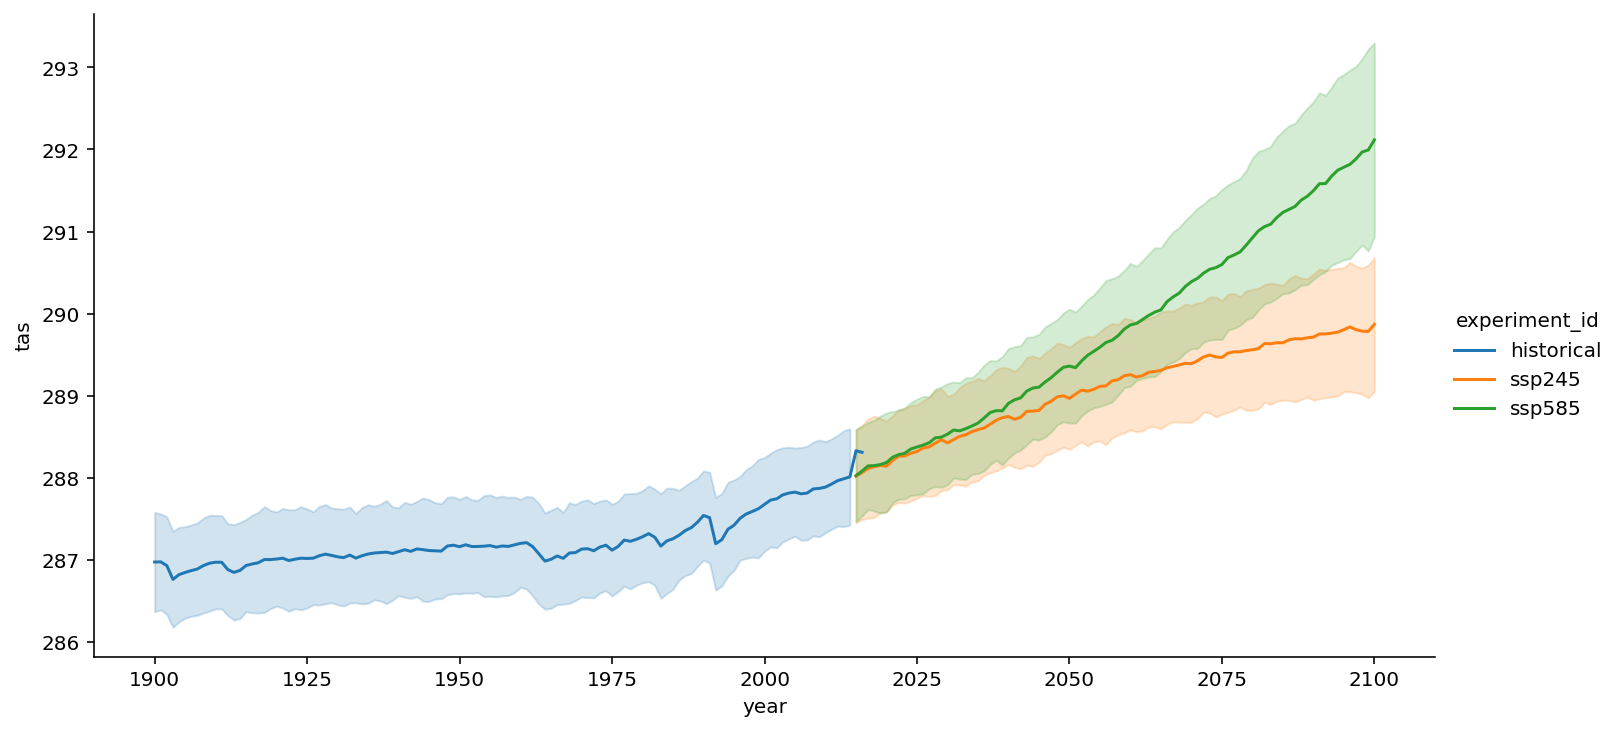

In [12]:
sns.relplot(data=df_all, x="year", y="tas", hue='experiment_id', kind="line", ci="sd", aspect=2);

In [13]:
# why are there axis legends for 9, 10 - doesn't make sense
df_all.experiment_id.unique()

array(['historical', 'ssp245', 'ssp585'], dtype=object)